<a href="https://colab.research.google.com/github/Salsabilaurelia1408/tugasakhirsalsa/blob/main/Tuning_LookBack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [6]:
def reshape_data(data, look_back):
    X = []
    Y = []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

def create_gru_model(look_back, dropout):
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=(look_back, 5)))
    model.add(Dense(1))
    model.add(Dropout(dropout))
    model.compile(optimizer='adam', loss='mse')
    return model

In [7]:
# Load data
url = 'https://raw.githubusercontent.com/Salsabilaurelia1408/tugasakhirsalsa/main/WOPR2_DateFormatRevised.csv'
df = pd.read_csv(url, index_col='Time', parse_dates=True)
df.set_index('Date', inplace=True)
df.index.freq = 'MS'

# Define input and output variables
X = df[['WOPR', 'WBHP', 'WWPR', 'WGPR', 'GOR']]
Y = df['WOPR']

Look Back=1: Loss=0.00036734092282131314, Loss_dev=0.0008883083937689662
Look Back=5: Loss=0.004683906678110361, Loss_dev=0.0005147694610059261
Look Back=10: Loss=2.569458774814848e-05, Loss_dev=0.0003477083519101143
Look Back=15: Loss=0.00024046078033279628, Loss_dev=0.00010426460357848555
Look Back=20: Loss=3.100291360169649e-05, Loss_dev=0.00023825843527447432
Look Back=25: Loss=0.0015602628700435162, Loss_dev=0.00011223508045077324
Look Back=30: Loss=9.48300748859765e-06, Loss_dev=2.7870586563949473e-05
Look Back=35: Loss=0.0011293113930150867, Loss_dev=8.140427235048264e-05
Look Back=40: Loss=0.0014435505727306008, Loss_dev=0.00016267933824565262


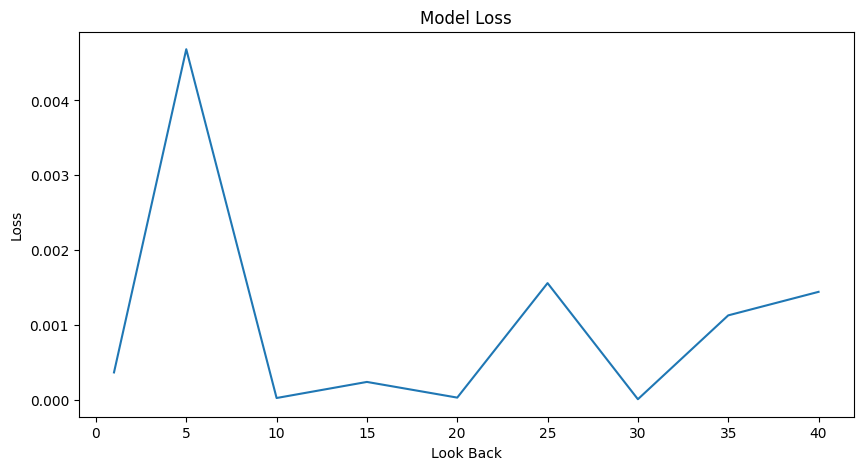

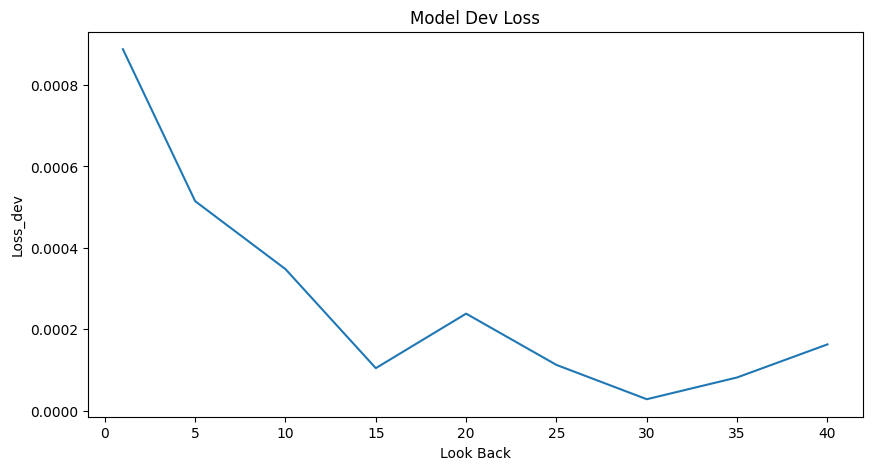

In [8]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(np.array(Y).reshape(-1, 1))


# Define training and testing data
train_size = int(len(df) * 0.7)  # 80% for training, 20% for testing
dev_size = int(len(df)*0.15)
test_size = int(len(df)-(train_size+dev_size))

X_train = X_scaled[:train_size]
Y_train = Y_scaled[1:train_size + 1]
X_dev = X_scaled[train_size:train_size + dev_size]
Y_dev = Y_scaled[train_size + 1:train_size + dev_size + 1]
X_test = X_scaled[train_size + dev_size:]
Y_test = Y_scaled[train_size + dev_size + 1:]

look_back_values = [1, 5, 10, 15, 20, 25, 30, 35, 40]
model_loss = []
model_loss_dev = []


for look_back in look_back_values:
    X_train_reshaped, Y_train_reshaped = reshape_data(X_train, look_back)
    X_dev_reshaped, Y_dev_reshaped = reshape_data(X_dev, look_back)
    X_test_reshaped, Y_test_reshaped = reshape_data(X_test, look_back)
    
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=(look_back, 5)))
    model.add(Dense(1))
    model.add(Dropout(0.1))
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train_reshaped, Y_train_reshaped, epochs=50, batch_size=32, validation_data=(X_dev_reshaped, Y_dev_reshaped), callbacks=[early_stop], verbose=0)
    loss = model.evaluate(X_test_reshaped, Y_test_reshaped, verbose=0)
    loss_dev = model.evaluate(X_dev_reshaped, Y_dev_reshaped, verbose=0)
    model_loss.append(loss)
    model_loss_dev.append(loss_dev)
    
    print(f"Look Back={look_back}: Loss={loss}, Loss_dev={loss_dev}")

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(look_back_values, model_loss)
plt.title("Model Loss")
plt.xlabel("Look Back")
plt.ylabel("Loss")
plt.show()

# Plot the dev loss values
plt.figure(figsize=(10, 5))
plt.plot(look_back_values, model_loss_dev)
plt.title("Model Dev Loss")
plt.xlabel("Look Back")
plt.ylabel("Loss_dev")
plt.show()